## Declaracion de funciones

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, classification_report

import xgboost

from joblib import dump, load

import random
random.seed(42)

first = lambda x : x.value_counts().index[0]

reducir_marca = lambda x : 0 if (x == 0) else 2

# Lectura de los datos
valid_data = pd.read_csv('valid_data.csv')
valid_data.drop(columns=['fecha'], inplace=True)

tap_data = pd.read_csv('tap_data.csv')

# Los datos diurnos se filtran con 12 <= hora <= 20
# y se elimina la hora
daytime_data = tap_data[tap_data['hora'] >= 12]
daytime_data = daytime_data[daytime_data['hora'] <= 20]
daytime_data.drop(columns=['hora'], inplace=True)

# Datos
data = valid_data.copy()
data['marca'] = data['marca'].apply(reducir_marca)
tap_data['marca'] = tap_data['marca'].apply(reducir_marca)
daytime_data['marca'] = daytime_data['marca'].apply(reducir_marca)

In [2]:
import matplotlib.pyplot as plt

# Plotea la curva roc, indicando el valor de AUC
def PlotAUC(fp_rate1, fp_rate2, tp_rate1, tp_rate2, score1, score2, out_name):
    plt.rcParams.update({'font.size': 18})
    plt.subplots(1, figsize=(10,10))
    plt.suptitle('Area Under ROC', fontsize=20)
    plt.plot(fp_rate1, tp_rate1, label='AUC_rf = '+str(score1))
    
    plt.plot(fp_rate2, tp_rate2, label='AUC_xgb = '+str(score2))
        
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.savefig('plots/' + out_name + '.png')
    plt.show()

## Hiperparámetros de los modelos

In [3]:
rfc = RandomForestClassifier()
xgb = xgboost.XGBClassifier()

rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [4]:
xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

## Hiperparámetros con GRIDSEARCHCV

In [5]:
window_size = 15
size = 50000
# True -> se entrenan los modelos finales, False -> se leen los modelos
train_models = True


# Se selecciona una porcion de size datos consecutivos
idx = random.randint(0, data.shape[0]-size)
sample = data.loc[idx:idx+size,:].copy()


X = sample.drop(columns=['marca'])
X = X.rolling(window=window_size).apply(np.mean)
X.dropna(inplace=True)

y = sample['marca'].copy()
y = y.rolling(window=window_size).apply(first)
y.dropna(inplace=True)

# PCA 
pca = PCA(n_components=0.99)
X = pca.fit_transform(X)

### Random Forest

In [6]:
param_grid_rf = { 
    'n_estimators': [50, 100, 200, 500],
    'max_depth' : [4, 6, 8, 10],
    'max_features': ['sqrt', 'log2'],
    'criterion' : ['gini', 'entropy']
}


rfc = RandomForestClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rf, cv=skf, n_jobs=-1)
CV_rfc.fit(X, y)

CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'sqrt',
 'n_estimators': 200}

### xGBoost

In [7]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth' : [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma' : [0.1, 1, 10]
}

# Para xgb, se necesita codificar las etiquetas
le = LabelEncoder()
y_lab = pd.DataFrame(le.fit_transform(y))


xgb = xgboost.XGBClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5)
CV_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=skf, n_jobs=-1)
CV_xgb.fit(X, y_lab)

CV_xgb.best_params_

{'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 50}

## TAP Data

In [8]:
# Se selecciona una porcion de size datos consecutivos
idx = random.randint(0, tap_data.shape[0]-size)
sample = tap_data.loc[idx:idx+size,:].copy()


X = sample.drop(columns=['marca'])
X = X.rolling(window=window_size).apply(np.mean)
X.dropna(inplace=True)

y = sample['marca'].copy()
y = y.rolling(window=window_size).apply(first)
y.dropna(inplace=True)

# PCA 
pca = PCA(n_components=0.99)
X = pca.fit_transform(X)

### RF

In [9]:
rfc = RandomForestClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5)
CV_rfc_tap = GridSearchCV(estimator=rfc, param_grid=param_grid_rf, cv=skf, n_jobs=-1)
CV_rfc_tap.fit(X, y)

CV_rfc_tap.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'n_estimators': 200}

### XGB

In [10]:
# Para xgb, se necesita codificar las etiquetas
le = LabelEncoder()
y_lab = pd.DataFrame(le.fit_transform(y))


xgb = xgboost.XGBClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5)
CV_xgb_tap = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=skf, n_jobs=-1)
CV_xgb_tap.fit(X, y_lab)

CV_xgb_tap.best_params_

{'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}

## DAYTIME Data

In [11]:
# Se selecciona una porcion de size datos consecutivos
idx = random.randint(0, daytime_data.shape[0]-size)
sample = daytime_data.loc[idx:idx+size,:].copy()


X = sample.drop(columns=['marca'])
X = X.rolling(window=window_size).apply(np.mean)
X.dropna(inplace=True)

y = sample['marca'].copy()
y = y.rolling(window=window_size).apply(first)
y.dropna(inplace=True)

# PCA 
pca = PCA(n_components=0.99)
X = pca.fit_transform(X)

### RF

In [12]:
rfc = RandomForestClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5)
CV_rfc_day = GridSearchCV(estimator=rfc, param_grid=param_grid_rf, cv=skf, n_jobs=-1)
CV_rfc_day.fit(X, y)

CV_rfc_day.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 100}

### XGB

In [13]:
# Para xgb, se necesita codificar las etiquetas
le = LabelEncoder()
y_lab = pd.DataFrame(le.fit_transform(y))


xgb = xgboost.XGBClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5)
CV_xgb_day = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=skf, n_jobs=-1)
CV_xgb_day.fit(X, y_lab)

CV_xgb_day.best_params_

{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}

---

# Generación Modelos Finales

Entrenamiento de modelos finales y plot de los resultados de AUC.
NOTA: Se han generado y guardado previamente los modelos en archivos *joblib*, para ahorrar el tiempo de entrenamiento

## Datos completos

In [14]:
pca_out = PCA(0.99)

X = pd.DataFrame(pca_out.fit_transform(data.drop(columns=['marca'])))
y = data['marca'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42, shuffle=False)

if train_models:
    rfc = RandomForestClassifier(**CV_rfc.best_params_)
    rfc.fit(X_train, y_train)

    dump (rfc, 'rf-model.joblib')
else:
    rfc = load('rf-model.joblib')
y_pred = rfc.predict(X_test)

fp_rate_rf, tp_rate_rf, threshold = roc_curve(y_test, y_pred, pos_label=2)
score_rf = roc_auc_score(y_test, y_pred)

display(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

array([[196579,  19622],
       [ 13851,  78138]])

              precision    recall  f1-score   support

           0       0.93      0.91      0.92    216201
           2       0.80      0.85      0.82     91989

    accuracy                           0.89    308190
   macro avg       0.87      0.88      0.87    308190
weighted avg       0.89      0.89      0.89    308190



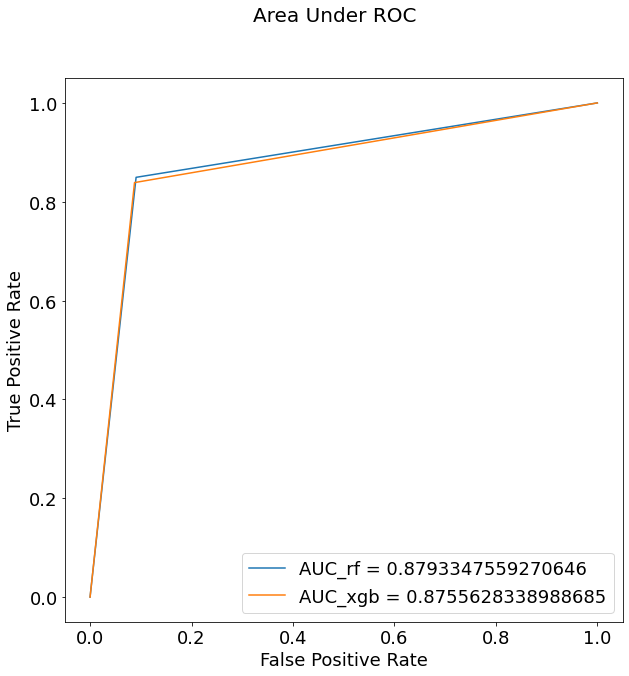

array([[197256,  18945],
       [ 14833,  77156]])

              precision    recall  f1-score   support

           0       0.93      0.91      0.92    216201
           1       0.80      0.84      0.82     91989

    accuracy                           0.89    308190
   macro avg       0.87      0.88      0.87    308190
weighted avg       0.89      0.89      0.89    308190



In [15]:
le = LabelEncoder()
y_lab = pd.DataFrame(le.fit_transform(y))
X_train, X_test, y_train, y_test = train_test_split(X, y_lab, test_size=0.20, random_state = 42, shuffle=False)
 
if train_models:
    xgb = xgboost.XGBClassifier(**CV_xgb.best_params_)
    xgb.fit(X_train, y_train)
    dump (xgb, 'xgb-model.joblib')
    
else:
    xgb = load('xgb-model.joblib')

y_pred = xgb.predict(X_test)

fp_rate_xgb, tp_rate_xgb, threshold = roc_curve(y_test, y_pred, pos_label=1)
score_xgb = roc_auc_score(y_test, y_pred)

PlotAUC(fp_rate_rf, fp_rate_xgb, tp_rate_rf, tp_rate_xgb, score_rf, score_xgb, 'normal-auc')
display(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

## TAP

In [16]:
pca_out = PCA(0.99)

X = pd.DataFrame(pca_out.fit_transform(tap_data.drop(columns=['marca'])))
y = tap_data['marca'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42, shuffle=False)
 
if train_models:
    rfc = RandomForestClassifier(**CV_rfc_tap.best_params_)
    rfc.fit(X_train, y_train)
    dump (rfc, 'rf-model-tap.joblib')
else:
    rfc = load('rf-model-tap.joblib')

y_pred = rfc.predict(X_test)

fp_rate_rf, tp_rate_rf, threshold = roc_curve(y_test, y_pred, pos_label=2)
score_rf = roc_auc_score(y_test, y_pred)

display(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

array([[199017,  14719],
       [  6975,  87479]])

              precision    recall  f1-score   support

           0       0.97      0.93      0.95    213736
           2       0.86      0.93      0.89     94454

    accuracy                           0.93    308190
   macro avg       0.91      0.93      0.92    308190
weighted avg       0.93      0.93      0.93    308190



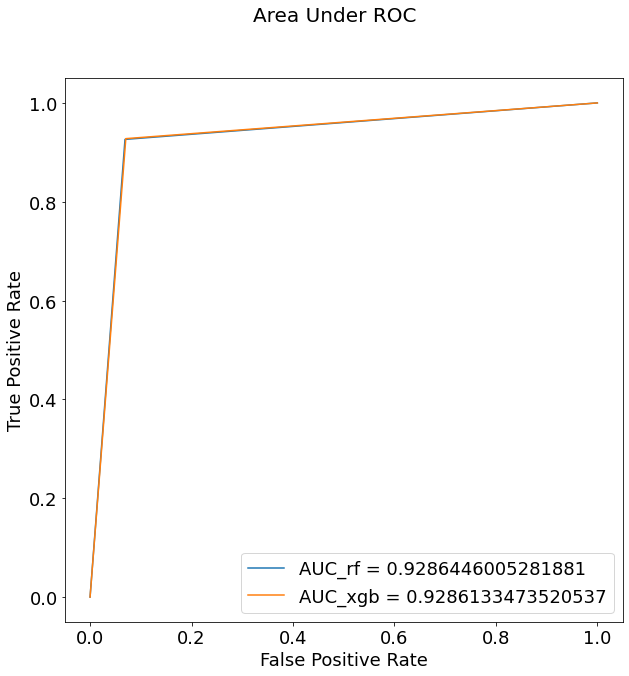

array([[198671,  15065],
       [  6828,  87626]])

              precision    recall  f1-score   support

           0       0.97      0.93      0.95    213736
           1       0.85      0.93      0.89     94454

    accuracy                           0.93    308190
   macro avg       0.91      0.93      0.92    308190
weighted avg       0.93      0.93      0.93    308190



In [17]:
le = LabelEncoder()
y_lab = pd.DataFrame(le.fit_transform(y))
X_train, X_test, y_train, y_test = train_test_split(X, y_lab, test_size=0.20, random_state = 42, shuffle=False)
 
if train_models:
    xgb = xgboost.XGBClassifier(**CV_xgb_tap.best_params_)
    xgb.fit(X_train, y_train)
    dump(xgb, 'xgb-model-tap.joblib')
else:
    xgb = load('xgb-model-tap.joblib')
y_pred = xgb.predict(X_test)

fp_rate_xgb, tp_rate_xgb, threshold = roc_curve(y_test, y_pred, pos_label=1)
score_xgb = roc_auc_score(y_test, y_pred)

PlotAUC(fp_rate_rf, fp_rate_xgb, tp_rate_rf, tp_rate_xgb, score_rf, score_xgb, 'tap-auc')

display(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

## Daytime

In [18]:
pca_out = PCA(0.99)

X = pd.DataFrame(pca_out.fit_transform(daytime_data.drop(columns=['marca'])))
y = daytime_data['marca'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42, shuffle=False)

if train_models:
    rfc = RandomForestClassifier(**CV_rfc_day.best_params_)
    rfc.fit(X_train, y_train)

    dump (rfc, 'rf-model-daytime.joblib')
else:
    rfc = load('rf-model-daytime.joblib')

y_pred = rfc.predict(X_test)

fp_rate_rf, tp_rate_rf, threshold = roc_curve(y_test, y_pred, pos_label=2)
score_rf = roc_auc_score(y_test, y_pred)

display(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

array([[91166,  1630],
       [ 1772,  3475]])

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     92796
           2       0.68      0.66      0.67      5247

    accuracy                           0.97     98043
   macro avg       0.83      0.82      0.83     98043
weighted avg       0.96      0.97      0.97     98043



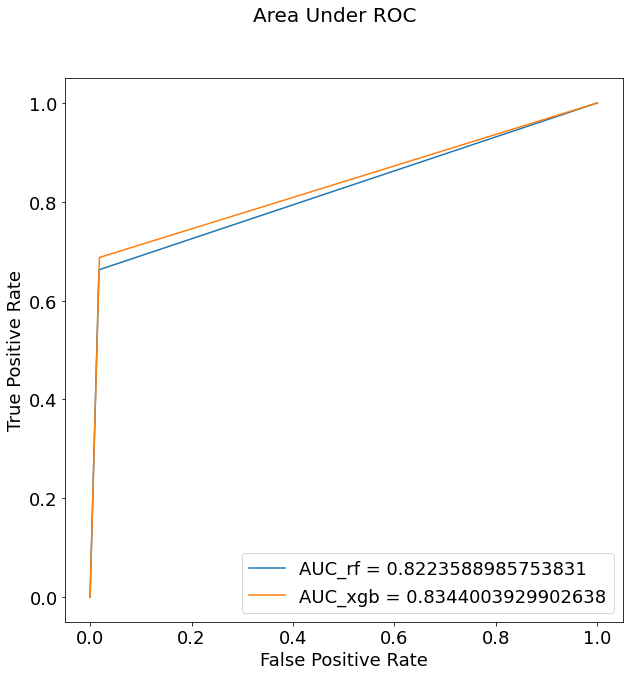

array([[91084,  1712],
       [ 1641,  3606]])

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     92796
           1       0.68      0.69      0.68      5247

    accuracy                           0.97     98043
   macro avg       0.83      0.83      0.83     98043
weighted avg       0.97      0.97      0.97     98043



In [19]:
le = LabelEncoder()
y_lab = pd.DataFrame(le.fit_transform(y))
X_train, X_test, y_train, y_test = train_test_split(X, y_lab, test_size=0.20, random_state = 42, shuffle=False)
 
if train_models:
    xgb = xgboost.XGBClassifier(**CV_xgb_day.best_params_)
    xgb.fit(X_train, y_train)
    dump (xgb, 'xgb-model-daytime.joblib')
else:
    xgb = load('xgb-model-daytime.joblib')

y_pred = xgb.predict(X_test)

fp_rate_xgb, tp_rate_xgb, threshold = roc_curve(y_test, y_pred, pos_label=1)
score_xgb = roc_auc_score(y_test, y_pred)

PlotAUC(fp_rate_rf, fp_rate_xgb, tp_rate_rf, tp_rate_xgb, score_rf, score_xgb, 'day-auc')

display(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))